In [4]:
import numpy as np
from tqdm import tqdm
import os

In [5]:
root = "./../Data/"
sub_folder = "FD_Y/"

TEMPORAL_PRECISION = "Y"
TEMPORAL_LIMIT_START = np.datetime64("-1000-01-01", TEMPORAL_PRECISION)
TEMPORAL_LIMIT_END = np.datetime64("2023-05-25", TEMPORAL_PRECISION)


In [6]:
def process_time(time_raw:str, time_precision:str, Unknown:str="Unknown") -> np.datetime64:
	if time_raw == Unknown:
		return Unknown
	return np.datetime64(time_raw, time_precision)

def read_data(path:str, type_data:str="OP", time_precision:str="D", Unknown:str="Unknown") -> set:
	is_OP = type_data == "OP"
	result_set = set()
	with open(f"{path}", "r", encoding="UTF-8") as f_r:
		line = f_r.readline()
		try:
			while line != "":
				split = line[:-2].split("\t")
				if len(split) == 4:
					result_set.add(tuple([
						split[0], 
						split[1], 
						split[2], 
						process_time(time_raw=split[3], time_precision=time_precision), 
						is_OP
					]))
				else:
					start = process_time(time_raw=split[3], time_precision=time_precision)
					end = process_time(time_raw=split[4], time_precision=time_precision)
					if start != Unknown and end != Unknown:
						if start > end : 
							print(line)
						elif start == end :
							end = start + np.timedelta64(1, time_precision)

					result_set.add(tuple([
						split[0], 
						split[1], 
						split[2], 
						(start, end), 
						is_OP
					]))
				line = f_r.readline()
		except Exception as e :
			print(e)
			print(line)

	return result_set

def create_folder(directory:str):
	if not os.path.exists(directory):
		os.makedirs(directory)

def create_indexes(graph:set):
	cpt_entity = 0 
	index_entity = dict()

	cpt_relation = 0 
	index_relation = dict()

	for line in graph:
		h, r, o, time, is_object = line

		h = h
		if h not in index_entity:
			index_entity[h] = cpt_entity
			cpt_entity += 1 
		
		r = r
		if r not in index_relation:
			index_relation[r] = cpt_relation
			cpt_relation += 1 

		if is_object:
			o = o
			if o not in index_entity:
				index_entity[o] = cpt_entity
				cpt_entity += 1

	return index_entity, index_relation

In [7]:
data_OP = read_data(path=f"{root}{sub_folder}Temporary/OP_prepro.nt", 
					type_data="OP",
					time_precision=TEMPORAL_PRECISION)
data_DP = read_data(path=f"{root}{sub_folder}Temporary/DP_prepro.nt",
					type_data="DP",
					time_precision=TEMPORAL_PRECISION)

/tmp/ipykernel_59851/177145439.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  return np.datetime64(time_raw, time_precision)


In [8]:

for line in data_OP.union(data_DP):
	time = line[3]
	if type(time)==tuple:
		if time[0] != "Unknown" and (time[0]<TEMPORAL_LIMIT_START or time[0]>TEMPORAL_LIMIT_END):
			print(line)
		if time[1] != "Unknown" and (time[1]<TEMPORAL_LIMIT_START or time[1]>TEMPORAL_LIMIT_END):
			print(line)
	else :
		if time<TEMPORAL_LIMIT_START or time>TEMPORAL_LIMIT_END:
			print(line)


('Q116895996', 'P669', 'Q59158092', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q97352063', 'P5817', 'Q109551035', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q117816594', 'P915', 'Q751961', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q581423', 'P286', 'Q107975188', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q102300538', 'P54', 'Q47150822', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q23059645', 'P54', 'Q111912034', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q116480776', 'P39', 'Q21295141', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q17538712', 'P1308', 'Q118495539', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q100879242', 'P54', 'Q107411717', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q55978517', 'P54', 'Q87367831', (numpy.datetime64('2023'), numpy.datetime64('2024')), True)
('Q116895996', 'P793', 'Q464980', (numpy.dateti

In [9]:
data_merged = data_OP.union(data_DP)

In [7]:
limits = [1,2,3,4,5,6,7,8,9,10, 12, 13, 14, 15]
extracted_graph_dropped = data_OP
metadata = []
for limit in limits:
	first = True
	stop = 1000
	cpt = 0
	to_drop = set()
	while len(to_drop) != 0 or first:
		first = False
		population_entities = dict()
		
		for h, r, o, _, is_object in extracted_graph_dropped:

			#if h not in population_entities:
			#	population_entities[h] = 0
			#population_entities[h] += 1 
			#if is_object:
			#	if o not in population_entities:
			#		population_entities[o] = 0
			#	population_entities[o] += 1 

			
			#if h not in population_entities:
			#	population_entities[h] = set()
			#population_entities[h].add(r)
			#if is_object:
			#	if o not in population_entities:
			#		population_entities[o] = set()
			#	population_entities[o].add(r)	

			if h not in population_entities:
				population_entities[h] = set()
			population_entities[h].add(o)
			if is_object:
				if o not in population_entities:
					population_entities[o] = set()
				population_entities[o].add(h)	

		#to_drop = set()
		#for e in population_entities:
		#	if population_entities[e] < limit:
		#		to_drop.add(e)

		to_drop = set()
		for e in population_entities:
			if len(population_entities[e]) < limit:
				to_drop.add(e)

		extracted_graph_dropped = {line for line in extracted_graph_dropped if line[0] not in to_drop and line[2] not in to_drop}

		#print(len(extracted_graph_dropped)/len(data_OP))
		cpt += 1 
		if stop == cpt:
			break
	print(limit, np.around(len(extracted_graph_dropped)/len(data_OP)*100, 3))
	ie, _ = create_indexes(extracted_graph_dropped)
	metadata.append((len(extracted_graph_dropped)/len(data_OP)*100, len(ie)))


1 100.0
2 51.853
3 30.427
4 19.435
5 13.251
6 9.296
7 6.688
8 4.68
9 3.176
10 1.92
12 0.289
13 0.156
14 0.13
15 0.111


In [8]:
metadata

[(100.0, 6840803),
 (51.852696558193955, 1845056),
 (30.426859674294132, 730123),
 (19.43494175262767, 359746),
 (13.251018346268337, 203032),
 (9.29602112361799, 122981),
 (6.688180512516766, 79513),
 (4.680040339835441, 51020),
 (3.1760014998237924, 32291),
 (1.920137315245771, 18261),
 (0.2886024570793644, 2061),
 (0.1560208927067036, 896),
 (0.13045571442211426, 658),
 (0.11054419742841795, 464)]

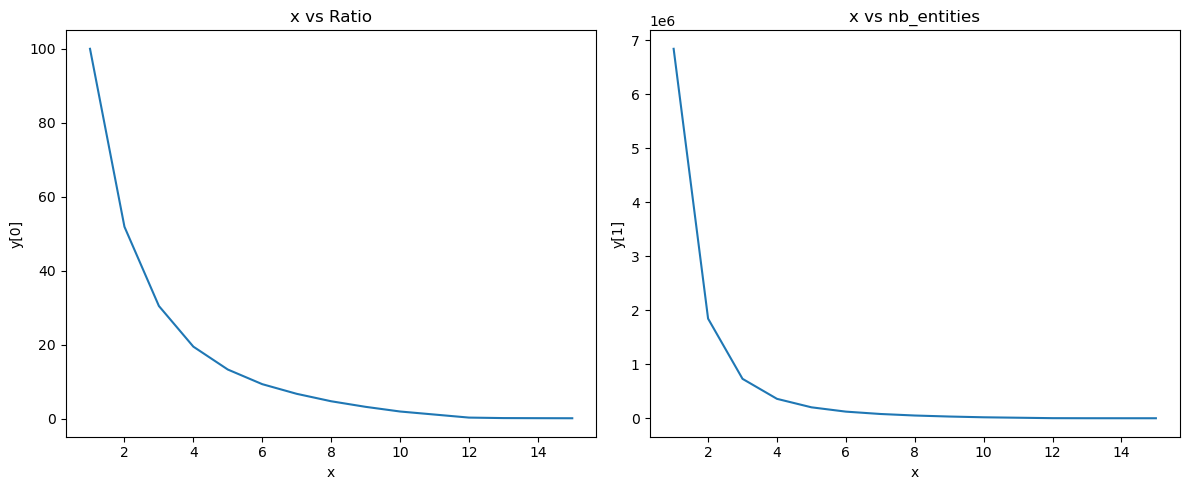

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Split y into two separate lists
ratio_graph = [val[0] for val in metadata]
nb_entities = [val[1] for val in metadata]

# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot: x vs y1
sns.lineplot(x=limits, y=ratio_graph, ax=axes[0])
axes[0].set_title("x vs Ratio")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y[0]")
#axes[0].set_yscale("log")

# Second scatter plot: x vs y2
sns.lineplot(x=limits, y=nb_entities, ax=axes[1])
axes[1].set_title("x vs nb_entities")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y[1]")
#axes[1].set_yscale("log")

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
limits = [1,2,3,4,5,6,7,8,9,10,15]
extracted_graph_dropped = data_OP
metadata = []
for limit in limits:
	first = True
	stop = 1000
	cpt = 0
	to_drop = set()
	while len(to_drop) != 0 or first:
		first = False
		population_entities = dict()
		
		for h, r, o, _, is_object in extracted_graph_dropped:

			#if h not in population_entities:
			#	population_entities[h] = 0
			#population_entities[h] += 1 
			#if is_object:
			#	if o not in population_entities:
			#		population_entities[o] = 0
			#	population_entities[o] += 1 

			
			if h not in population_entities:
				population_entities[h] = set()
			population_entities[h].add(r)
			if is_object:
				if o not in population_entities:
					population_entities[o] = set()
				population_entities[o].add(r)	

			#if h not in population_entities:
			#	population_entities[h] = set()
			#population_entities[h].add(o)
			#if is_object:
			#	if o not in population_entities:
			#		population_entities[o] = set()
			#	population_entities[o].add(h)	

		#to_drop = set()
		#for e in population_entities:
		#	if population_entities[e] < limit:
		#		to_drop.add(e)

		to_drop = set()
		for e in population_entities:
			if len(population_entities[e]) < limit:
				to_drop.add(e)

		extracted_graph_dropped = {line for line in extracted_graph_dropped if line[0] not in to_drop and line[2] not in to_drop}

		#print(len(extracted_graph_dropped)/len(data_OP))
		cpt += 1 
		if stop == cpt:
			break
	print(limit, np.around(len(extracted_graph_dropped)/len(data_OP)*100, 3))
	ie, _ = create_indexes(extracted_graph_dropped)
	metadata.append((len(extracted_graph_dropped)/len(data_OP)*100, len(ie)))


1 100.0
2 17.356
3 1.02
4 0.069
5 0.008
6 0.001
7 0.0
8 0.0
9 0.0
10 0.0
15 0.0


In [ ]:
metadata

[(100.0, 6384738),
 (51.44343002792995, 1703340),
 (29.86076999697675, 661466),
 (19.15006995850798, 326182),
 (13.097129572818522, 184342),
 (9.283881072714282, 112828),
 (6.731994271856366, 73541),
 (4.767820313844142, 47772),
 (3.2429188665434796, 30287),
 (1.9545716157534643, 17043),
 (0.11359471898893869, 443)]

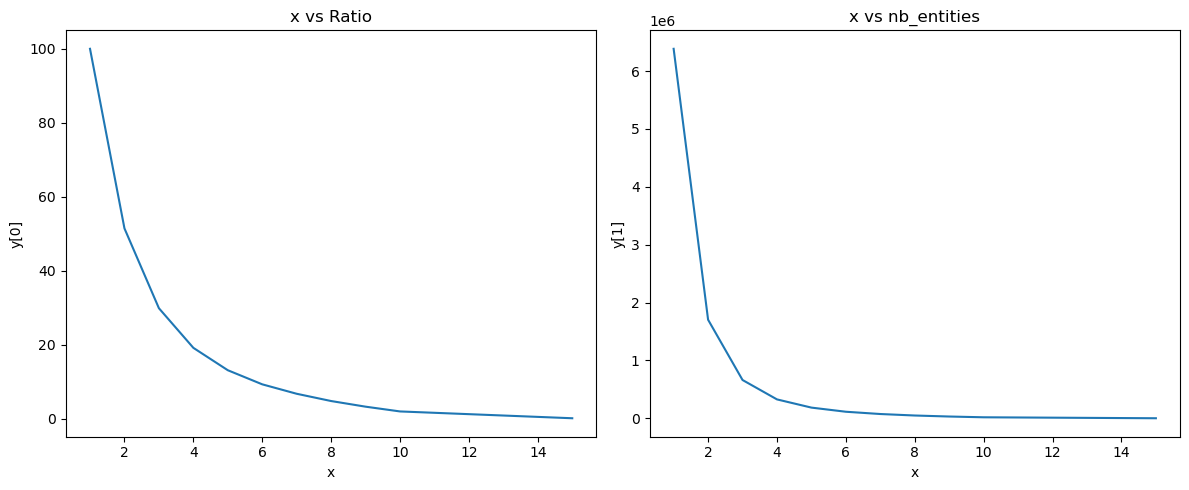

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Split y into two separate lists
ratio_graph = [val[0] for val in metadata]
nb_entities = [val[1] for val in metadata]

# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot: x vs y1
sns.lineplot(x=limits, y=ratio_graph, ax=axes[0])
axes[0].set_title("x vs Ratio")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y[0]")
#axes[0].set_yscale("log")

# Second scatter plot: x vs y2
sns.lineplot(x=limits, y=nb_entities, ax=axes[1])
axes[1].set_title("x vs nb_entities")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y[1]")
#axes[1].set_yscale("log")

# Show the plots
plt.tight_layout()
plt.show()


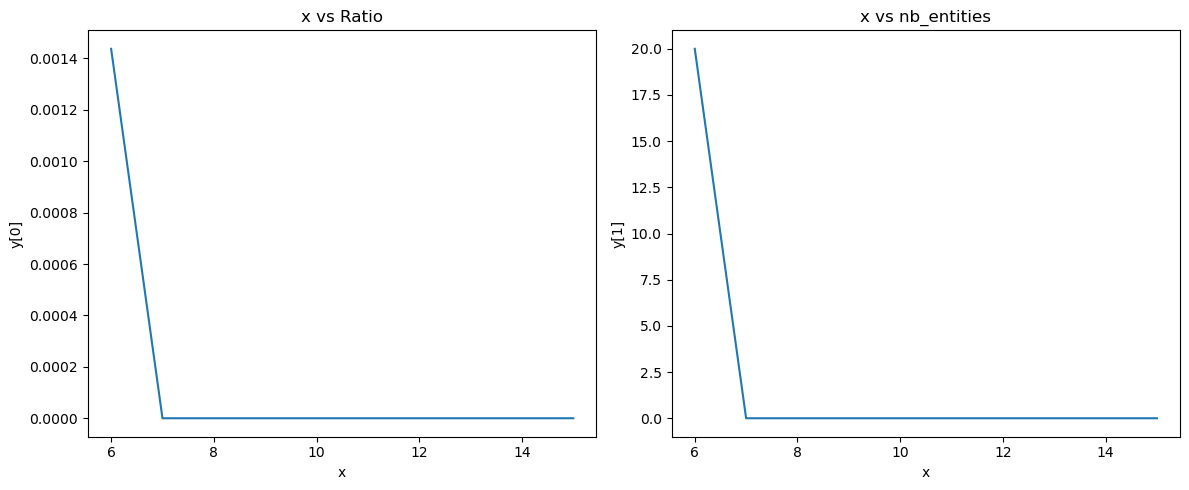

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Split y into two separate lists
ratio_graph = [val[0] for val in metadata[4:]]
nb_entities = [val[1] for val in metadata[4:]]

# Set up the matplotlib figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot: x vs y1
sns.lineplot(x=limits[4:], y=ratio_graph, ax=axes[0])
axes[0].set_title("x vs Ratio")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y[0]")
#axes[0].set_yscale("log")

# Second scatter plot: x vs y2
sns.lineplot(x=limits[4:], y=nb_entities, ax=axes[1])
axes[1].set_title("x vs nb_entities")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y[1]")
#axes[1].set_yscale("log")

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
stop = 1000
extracted_graph_dropped = data_OP
limits_selected = [4,8,10,15][-1:]
names = ["Large", "Medium", "Small", "Extra_Small"][-1:]



ids = {}
with open("./SaveRecursion/ids", "r", encoding="UTF-8") as f_w:
	line = f_w.readline()
	while line	!= "":
		i, e = line[:-1].split("\t")
		i = int(i)
		ids[i] = e
		line = f_w.readline()

for i, limit in tqdm(enumerate(limits_selected)):
	name = names[i]
	first = True
	cpt = 0
	to_drop = set()
	while len(to_drop) != 0 or first:
		first = False
		population_entities = dict()
		
		for h, r, o, _, is_object in extracted_graph_dropped:

			#if h not in population_entities:
			#	population_entities[h] = 0
			#population_entities[h] += 1 
			#if is_object:
			#	if o not in population_entities:
			#		population_entities[o] = 0
			#	population_entities[o] += 1 

			
			#if h not in population_entities:
			#	population_entities[h] = set()
			#population_entities[h].add(r)
			#if is_object:
			#	if o not in population_entities:
			#		population_entities[o] = set()
			#	population_entities[o].add(r)	

			if h not in population_entities:
				population_entities[h] = set()
			population_entities[h].add(o)
			if is_object:
				if o not in population_entities:
					population_entities[o] = set()
				population_entities[o].add(h)	

		#to_drop = set()
		#for e in population_entities:
		#	if population_entities[e] < limit:
		#		to_drop.add(e)

		to_drop = set()
		for e in population_entities:
			if len(population_entities[e]) < limit:
				to_drop.add(e)

		extracted_graph_dropped = {line for line in extracted_graph_dropped if line[0] not in to_drop and line[2] not in to_drop}

		#print(len(extracted_graph_dropped)/len(data_OP))
		cpt += 1 
		if stop == cpt:
			break
	print(limit, np.around(len(extracted_graph_dropped)/len(data_OP)*100, 3))
	print("Extraction Done")

	entities_selected = {line[0] for line in extracted_graph_dropped}.union({line[2] for line in extracted_graph_dropped})
	extracted_graph_dropped.update({line for line in data_DP if line[0] in entities_selected})
	print(len(extracted_graph_dropped)/len(data_merged))

	# Make sure that every relations have always the type of value (i.e. OP or DP)
	def return_the_type(values):
		if values[True] > values[False]:
			return False
		else:
			return True
		
	r_type = {}
	for fact in extracted_graph_dropped:
		if fact[1] not in r_type:
			r_type[fact[1]] = {True:0, False:0}
		r_type[fact[1]][fact[-1]] += 1

	for r in [r  for r in r_type if (r_type[r][True] != 0) and (r_type[r][False] != 0)]:
		print(r, r_type[r])

	type_relations = {r:"OP" if r_type[r][True]>r_type[r][False] else "DP" for r in r_type }
	stranges_r = [r  for r in r_type if (r_type[r][True] != 0) and (r_type[r][False] != 0)]

	errounous_facts = set()
	for fact in extracted_graph_dropped:
		if fact[1] in stranges_r and fact[-1] == return_the_type(r_type[r]):
			errounous_facts.add(fact)

	extracted_graph_dropped.difference_update(errounous_facts)
	for fe in errounous_facts:
		if type_relations[fe[1]] == "DP":
			extracted_graph_dropped.add((fe[0], fe[1], "unknown", fe[3], False))
		else:
			print("Unsupported Error")

	# Start Writing the data 
	create_folder(f"{root}{sub_folder}{name}")

	index_entity, index_relation = create_indexes(extracted_graph_dropped)

	with open(f"{root}{sub_folder}{name}/Entity2ID.txt", "w", encoding="UTF-8") as f_out:
		for e, i in index_entity.items():
			f_out.write(f"{e}\t{i}\n")

	with open(f"{root}{sub_folder}{name}/Relation2ID.txt", "w", encoding="UTF-8") as f_out:
		for r, i in index_relation.items():
			if type_relations[r] == "OP":
				f_out.write(f"{r}\t{i}\n")

	with open(f"{root}{sub_folder}{name}/Relation2ID_AND_DP.txt", "w", encoding="UTF-8") as f_out:
		for r, i in index_relation.items():
			f_out.write(f"{r}\t{i}\n")

	with open(f"{root}{sub_folder}Temporary/OP_reduced_{limit}.nt", "w", encoding="UTF-8") as f_out_OP:
		with open(f"{root}{sub_folder}Temporary/DP_reduced_{limit}.nt", "w", encoding="UTF-8") as f_out_DP:
			for h, r, v, t, is_object in extracted_graph_dropped:
				to_write_on = f_out_OP if is_object else f_out_DP
				to_write_on.write(f"{index_entity[h]}\t{index_relation[r]}\t")
				if is_object:
					to_write_on.write(f"{index_entity[v]}\t")
				else:
					to_write_on.write(f"{v}\t")
				if type(t) == tuple:
					to_write_on.write(f"{t[0]}\t{t[1]}.\n")
				else:
					to_write_on.write(f"{t}.\n")

	# Write the classes to finished 
	classes_per_ents = dict()
	index_classes = dict()
	cpt_index_classes = 0
	with open(f"{root}Raw/res_classes.nt", "r", encoding="UTF-8") as f_r:
		line = f_r.readline()

		while line != "":
			
			s,_,o = line[:-2].split("\t")
			s = s[1:-1].split("/")[-1]
			o = o[1:-1].split("/")[-1]

			if s in index_entity:
				if index_entity[s] not in classes_per_ents:
					classes_per_ents[index_entity[s]] = set()

				if o not in index_classes:
					index_classes[o] = cpt_index_classes
					cpt_index_classes+=1
				classes_per_ents[index_entity[s]].add(index_classes[o])
			
			line = f_r.readline()
		
	cpt=0
	rejected = set()

	classes_and_subclass_per_entity = {}
	with open("./SaveRecursion/res_recursion", "r", encoding="UTF-8") as f_w:
		line = f_w.readline()
		while line	!= "":
			elts = (line[:-2].split("\t"))
			if len(elts) == 2:
				c, ents = elts
				for ent_id in ents.split(" "):
					ent = ids[int(ent_id)]
					if ent in index_entity:
						ent_indexed = index_entity[ent]
						if ent_indexed not in classes_and_subclass_per_entity:
							classes_and_subclass_per_entity[ent_indexed] = set()
						if c not in index_classes:
							index_classes[c] = cpt_index_classes
							cpt_index_classes += 1
						classes_and_subclass_per_entity[ent_indexed].add(index_classes[c])
					else:
						cpt +=1
						rejected.add(ent)
			line = f_w.readline()

	with open(f"{root}{sub_folder}{name}/Class2ID.txt", "w", encoding="UTF-8") as f_out:
		for c in index_classes:
			f_out.write(f"{c}\t{index_classes[c]}\n")

	with open(f"{root}{sub_folder}{name}/ClassPerEntity.txt", "w", encoding="UTF-8") as f_out:
		for e in classes_per_ents:
			f_out.write(f"{e}\t")
			to_write = ""
			for c in classes_per_ents[e]:
				to_write+=f"{c} "
			f_out.write(f"{to_write[:-1]}\n")

	with open(f"{root}{sub_folder}{name}/ClassPerEntityExtended.txt", "w", encoding="UTF-8") as f_out:
		for e in classes_and_subclass_per_entity:
			f_out.write(f"{e}\t")
			to_write = ""
			for c in classes_and_subclass_per_entity[e]:
				to_write+=f"{c} "
			f_out.write(f"{to_write[:-1]}\n")

0it [00:00, ?it/s]

15 0.111
Extraction Done
0.002192558978028192


1it [06:27, 387.59s/it]
